# Sequence to Sequence attention model for machine translation

This notebook trains a sequence to sequence (seq2seq) model with two dot product attention implemented for Spanish to English translation.

The codes are built on TensorFlow Core tutorials: https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [ ]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

2.7.0





# Load data set




*   Clean the sentences by removing special characters.
*   Add a start and end token to each sentence.
*   Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
*   Pad each sentence to a maximum length.

In [ ]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) #normalization form D
      if unicodedata.category(c) != 'Mn') #Nonspacing Mark


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip()) # Lower and strip

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w) # add space
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",","¿")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  # remove extra space
  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [ ]:
en_sentence = u"May I borrow this @ book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> may i borrow this book ? <end>
<start> ¿ puedo tomar prestado este libro ? <end>


In [ ]:
# Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])
print(len(en), len(sp))

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
118964 118964


In [ ]:
# Tokenize the sentence into list of words(integers) and pad the sequence to the same length
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='') #filter lọc khỏi văn bản
  lang_tokenizer.fit_on_texts(lang) #cập nhật từ vựng nội bộ

  tensor = lang_tokenizer.texts_to_sequences(lang) # đưa sang vector integer

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

11 16


In [ ]:
inp_lang.word_index

{'<start>': 1,
 '<end>': 2,
 '.': 3,
 'tom': 4,
 '?': 5,
 '¿': 6,
 'es': 7,
 'no': 8,
 'el': 9,
 'a': 10,
 'que': 11,
 'me': 12,
 'la': 13,
 'de': 14,
 'un': 15,
 'esta': 16,
 'se': 17,
 'lo': 18,
 'mi': 19,
 'en': 20,
 'una': 21,
 'por': 22,
 'te': 23,
 'estoy': 24,
 'ella': 25,
 'yo': 26,
 '!': 27,
 'eso': 28,
 'le': 29,
 'esto': 30,
 'tu': 31,
 ',': 32,
 'los': 33,
 'aqui': 34,
 'soy': 35,
 'muy': 36,
 'tengo': 37,
 'puedo': 38,
 'las': 39,
 'gusta': 40,
 'mary': 41,
 'tiene': 42,
 'son': 43,
 'con': 44,
 'como': 45,
 'quien': 46,
 'estaba': 47,
 'su': 48,
 'este': 49,
 'favor': 50,
 'estas': 51,
 'eres': 52,
 'quiero': 53,
 'ellos': 54,
 'fue': 55,
 'bien': 56,
 'casa': 57,
 'ahora': 58,
 'tomas': 59,
 'donde': 60,
 'mas': 61,
 'estan': 62,
 'nos': 63,
 'he': 64,
 'solo': 65,
 'puede': 66,
 'ha': 67,
 'era': 68,
 'todos': 69,
 'al': 70,
 'para': 71,
 'ir': 72,
 'tan': 73,
 'todo': 74,
 'estamos': 75,
 'necesito': 76,
 'ya': 77,
 'nadie': 78,
 'puedes': 79,
 'trabajo': 80,
 'voy': 8

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))
print(input_tensor_train[0])
print(target_tensor_train[0])

24000 24000 6000 6000
[  1   6  28   7  15 140 363  15   8   5   2   0   0   0   0   0]
[  1   8  10   9 425 543   9  66   7   2   0]


# Create a tf.data datasest

The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:


*   Create a source dataset from your input data.
*   Apply dataset transformations to preprocess the data.
*   Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [ ]:
# Configuration 
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
steps_per_epoch_val = len(input_tensor_val)//BATCH_SIZE
embedding_dim = 256  # for word embedding
units = 1024  # dimensionality of the output space of RNN
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE) # suffle
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) #xóa phần thừa
validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

# Basic seq2seq model: encoder and decoder

Model groups layers into an object with training and inference features. Two ways to define tf model:

![alt text](https://i.ibb.co/c8JX8Cc/tf-Model.jpg)

Basic sequence to sequence model without attention:
![alt text](https://i.ibb.co/QN0tyMp/seq2seq.jpg)



In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,  # Whether to return the last output in the output sequence, or the full sequence. 
                                   return_state=True,  # Whether to return the last state in addition to the output.
                                   recurrent_initializer='glorot_uniform') # how to init weight

  def call(self, x, hidden): # match layer in model
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape)) #shape: số mẫu, độ dài vec, số chiều word_index
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
# class Decoder(tf.keras.Model):
#   def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
#     super(Decoder, self).__init__()
#     self.batch_sz = batch_sz
#     self.dec_units = dec_units
#     self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.gru = tf.keras.layers.GRU(self.dec_units,
#                                    return_sequences=True,
#                                    return_state=True,
#                                    recurrent_initializer='glorot_uniform')
#     self.fc = tf.keras.layers.Dense(vocab_size)


#   def call(self, x, hidden):
#     # x shape after passing through embedding == (batch_size, 1, embedding_dim)
#     x = self.embedding(x)

#     # passing the concatenated vector to the GRU
#     output, state = self.gru(x, initial_state = hidden)

#     # output shape == (batch_size * 1, hidden_size)
#     output = tf.reshape(output, (-1, output.shape[2]))

#     # output shape == (batch_size, vocab)
#     x = self.fc(output)
#     return x, state

In [ ]:
# tf.reshape([[1,2,3],[4,5,6]], (-1, 2))

In [ ]:
# decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# sample_decoder_output, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
#                                       sample_hidden)

# print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

# Dot-product attention

![alt text](https://i.ibb.co/TvhM1Z2/attention.jpg)

![alt text](https://i.ibb.co/bvrcptV/dotproduct.jpg)

In [ ]:
class DotProductAttention(tf.keras.layers.Layer):
  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # inner product, score shape == (batch_size, max_length, 1)
    score = query_with_time_axis * values
    score = tf.reduce_sum(score, axis=2)
    score = tf.expand_dims(score, 2)
    
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = DotProductAttention()
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


# Additive attention

![alt text](https://i.ibb.co/BqDYNP1/additive.jpg)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(query_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# Decoder layer with attention

![alt text](https://i.ibb.co/ZM25Zvv/Context-Vector.jpg)

In [ ]:
class DecoderWithAttention(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_layer = None):
    super(DecoderWithAttention, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = attention_layer

  def call(self, x, hidden, enc_output):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    attention_weights = None
    
    if self.attention:
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)
      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) #concat vector with input

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state = hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

# Define loss function

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. 
![alt text](https://i.ibb.co/GtD1vc9/cross-entropy.png)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #tính toán tổn thất chéo giữa nhãn và dự đoán

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) 
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
print(loss_object([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))
print(loss_function([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))

tf.Tensor([1.063386  1.3633859], shape=(2,), dtype=float32)
tf.Tensor(1.2133859, shape=(), dtype=float32)


# Training

@tf.function
In TensorFlow 2, eager execution is turned on by default. The user interface is intuitive and flexible (running one-off operations is much easier and faster), but this can come at the expense of performance and deployability. It is recommended to debug in eager mode, then decorate with @tf.function for better performance.

In TensorFlow 2.0, users should refactor their code into smaller functions which are called as needed. In general, it's not necessary to decorate each of these smaller functions with tf.function; only use tf.function to decorate high-level computations - for example, one step of training, or the forward pass of your model.

TensorFlow provides the tf.GradientTape API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually tf.Variables. TensorFlow "records" relevant operations executed inside the context of a tf.GradientTape onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
# Use gradient descent
def get_train_step_func():

  @tf.function
  def train_step(inp, targ, enc_hidden, encoder, decoder): #input, target
    loss = 0

    with tf.GradientTape() as tape: # for automatic differentiation
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden # đưa hidden state vào decoder

      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]): # đi qua từng decoder input
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss
    
  return train_step
    

In [ ]:
def caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder):
  loss = 0
  enc_output, enc_hidden = encoder(inp, enc_hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_function(targ[:, t], predictions)
    dec_input = tf.expand_dims(targ[:, t], 1)

  loss = loss / int(targ.shape[1])
  return loss

In [ ]:
def training_seq2seq(epochs, attention):
  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
  decoder = DecoderWithAttention(vocab_tar_size, embedding_dim, units, BATCH_SIZE, attention)
  train_step_func = get_train_step_func()
  training_loss = []
  validation_loss = []

  for epoch in range(epochs):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step_func(inp, targ, enc_hidden, encoder, decoder)
      total_loss += batch_loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss))
        
    enc_hidden = encoder.initialize_hidden_state()
    total_val_loss = 0
    for (batch, (inp, targ)) in enumerate(validation_dataset.take(steps_per_epoch)):
      val_loss = caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder)
      total_val_loss += val_loss

    training_loss.append(total_loss / steps_per_epoch)
    validation_loss.append(total_val_loss / steps_per_epoch_val)
    print('Epoch {} Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                        training_loss[-1], validation_loss[-1]))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  return encoder, decoder, training_loss, validation_loss

## Training seq2seq without attention



In [ ]:
# epochs = 10
# attention = None

# print("Running seq2seq model without attention")
# encoder, decoder, training_loss, validation_loss = training_seq2seq(epochs, attention)

# tloss = training_loss
# vloss = validation_loss

## Training seq2seq with dot product attention

In [ ]:
attention = DotProductAttention()
epochs = 10
print("Running seq2seq model with dot product attention")
encoder_dp, decoder_dp, training_loss, validation_loss = training_seq2seq(epochs, attention)

Running seq2seq model with dot product attention
Epoch 1 Batch 0 Loss 4.7113
Epoch 1 Batch 100 Loss 2.2252
Epoch 1 Batch 200 Loss 1.8527
Epoch 1 Batch 300 Loss 1.7917
Epoch 1 Loss 2.0328 Validation Loss 1.6162
Time taken for 1 epoch 78.5709798336029 sec

Epoch 2 Batch 0 Loss 1.4792
Epoch 2 Batch 100 Loss 1.4348
Epoch 2 Batch 200 Loss 1.3220
Epoch 2 Batch 300 Loss 1.3503
Epoch 2 Loss 1.3813 Validation Loss 1.2650
Time taken for 1 epoch 69.97269439697266 sec

Epoch 3 Batch 0 Loss 1.1551
Epoch 3 Batch 100 Loss 1.0240
Epoch 3 Batch 200 Loss 0.9837
Epoch 3 Batch 300 Loss 1.0008
Epoch 3 Loss 1.0121 Validation Loss 1.0542
Time taken for 1 epoch 59.9301221370697 sec

Epoch 4 Batch 0 Loss 0.7454
Epoch 4 Batch 100 Loss 0.7339
Epoch 4 Batch 200 Loss 0.6512
Epoch 4 Batch 300 Loss 0.6233
Epoch 4 Loss 0.7199 Validation Loss 0.9185
Time taken for 1 epoch 60.008312940597534 sec

Epoch 5 Batch 0 Loss 0.4479
Epoch 5 Batch 100 Loss 0.5269
Epoch 5 Batch 200 Loss 0.4938
Epoch 5 Batch 300 Loss 0.4540
Epoch 

In [ ]:
tloss = training_loss
vloss = validation_loss
tloss = np.vstack((tloss, training_loss))
vloss = np.vstack((vloss, validation_loss))

Text(0.5, 1.0, 'Validation loss')

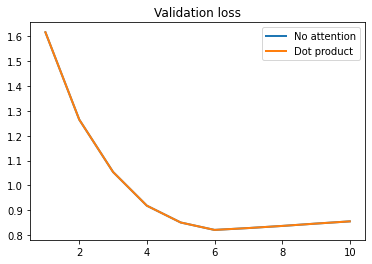

In [ ]:
import matplotlib.pyplot as plt

ax = plt.subplot(111) 
t = np.arange(1, epochs+1)

for i in range(0, vloss.shape[0]):
  line, = plt.plot(t, vloss[i,:], lw=2)

ax.legend(('No attention', 'Dot product', 'Bahdanau'))
ax.set_title("Validation loss")

## Training seq2seq with Bahdanau attention

In [ ]:
# epochs = 10

# attention = BahdanauAttention(units)
# print("Running seq2seq model with Bahdanau attention")
# encoder_bah, decoder_bah, training_loss, validation_loss = training_seq2seq(epochs, attention)

# tloss = np.vstack((tloss, training_loss))
# vloss = np.vstack((vloss, validation_loss))

NameError: ignored

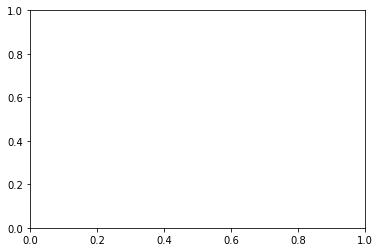

In [ ]:
# import matplotlib.pyplot as plt

# ax = plt.subplot(111) 
# t = np.arange(1, epochs+1)

# for i in range(0, vloss.shape[0]):
#   line, = plt.plot(t, vloss[i,:], lw=2)

# ax.legend(('No attention', 'Dot product', 'Bahdanau'))
# ax.set_title("Validation loss")


# Translation

In [ ]:
def translate(sentence, encoder, decoder):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    # until the predicted word is <end>.
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model, no teacher forcing.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [ ]:
# result, sentence = translate(u'esta es mi vida.', encoder_bah, decoder_bah)
# print('Input: %s' % (sentence))
# print('Predicted translation: {}'.format(result))

In [ ]:
result, sentence = translate(u'esta es mi vida.', encoder_dp, decoder_dp)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


In [ ]:
# result, sentence = translate(u'¿todavia estan en casa?', encoder_bah, decoder_bah)
# print('Input: %s' % (sentence))
# print('Predicted translation: {}'.format(result))

# Next Steps


*   Training on larger dataset
*   Model tuning
*   Try out other attention scores such as multiplicative
*   Train on other seq2seq tasks



